# MOSMAFS: Additional Figures

## Setup 

In [1]:
# Load packages 
library(data.table)
library(reshape2)
library(mlr)
library(ggplot2)
library(batchtools)
library(gridExtra)
library(ggpubr)
library(ggthemes)
library(scmamp)
library(plyr)


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Loading required package: ParamHelpers

'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).

Loading required package: magrittr


Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate




In [2]:
# stetup for nice plots 
theme_set(theme_pubr())
options(repr.plot.width=15, repr.plot.height=15)

In [3]:
source("../helpers.R")

In [4]:
# path where all results are stored 
respath = "result_data"

## Visualize Geometric vs. Binomial Initialization

In [6]:
args = readRDS("result_data/populations/args.rds")

In [16]:
savedir = "result_data/populations/results"
args = readRDS("result_data/populations/args.rds")
args = args[v %in% c("O", "OG", "OGHFiFmS"), ]
dirs = paste(savedir, "/", args$job.id, ".rds", sep = "")
pops = lapply(dirs, function(dir) {
    f = readRDS(dir)
    f[evals == 80, ]
})

In [17]:
names = Reduce(intersect, lapply(pops, names))
pops = lapply(pops, function(x) x[, ..names])
pops = do.call(rbind, pops)

In [22]:
table(pops$variant)


       O       OG OGHFiFmS 
   36000    36000    36000 

In [49]:
prob = "madelon"
lrn = "xgboost"

dfp = pops[learner == lrn & problem == prob, ]

dfp$perf.hout.perf = as.numeric(dfp$perf.hout.perf)
dfp$meanfeat.propfeat = as.numeric(dfp$meanfeat.propfeat)
# dfp = dfp[job.id %in% c(3241, 105921)]
dfp1 = dfp[variant == "O", ]
dfp2 = dfp[variant == "OG", ]
# dfp3 = dfp[variant == "OGHFiFmS", ]

dfpmat1 = t(as.matrix(dfp1[, c("perf.hout.perf", "meanfeat.propfeat")]))
dfp1$nondominated = as.vector(ecr::nondominated(dfpmat1))
dfpmat2 = t(as.matrix(dfp2[, c("perf.hout.perf", "meanfeat.propfeat")]))
dfp2$nondominated = as.vector(ecr::nondominated(dfpmat2))
# dfpmat3 = t(as.matrix(dfp3[, c("perf.hout.perf", "meanfeat.propfeat")]))
# dfp3$nondominated = as.vector(ecr::nondominated(dfpmat3))
dfp = rbind(dfp1, dfp2)
# dfp = rbind(dfp, dfp3)

dfp$variant = revalue(dfp$variant, c("O" = "Binomial", "OG" = "Geometric", "OGHFiFmS" = "Filter-Ensemble"))

The following `from` values were not present in `x`: OGHFiFmS



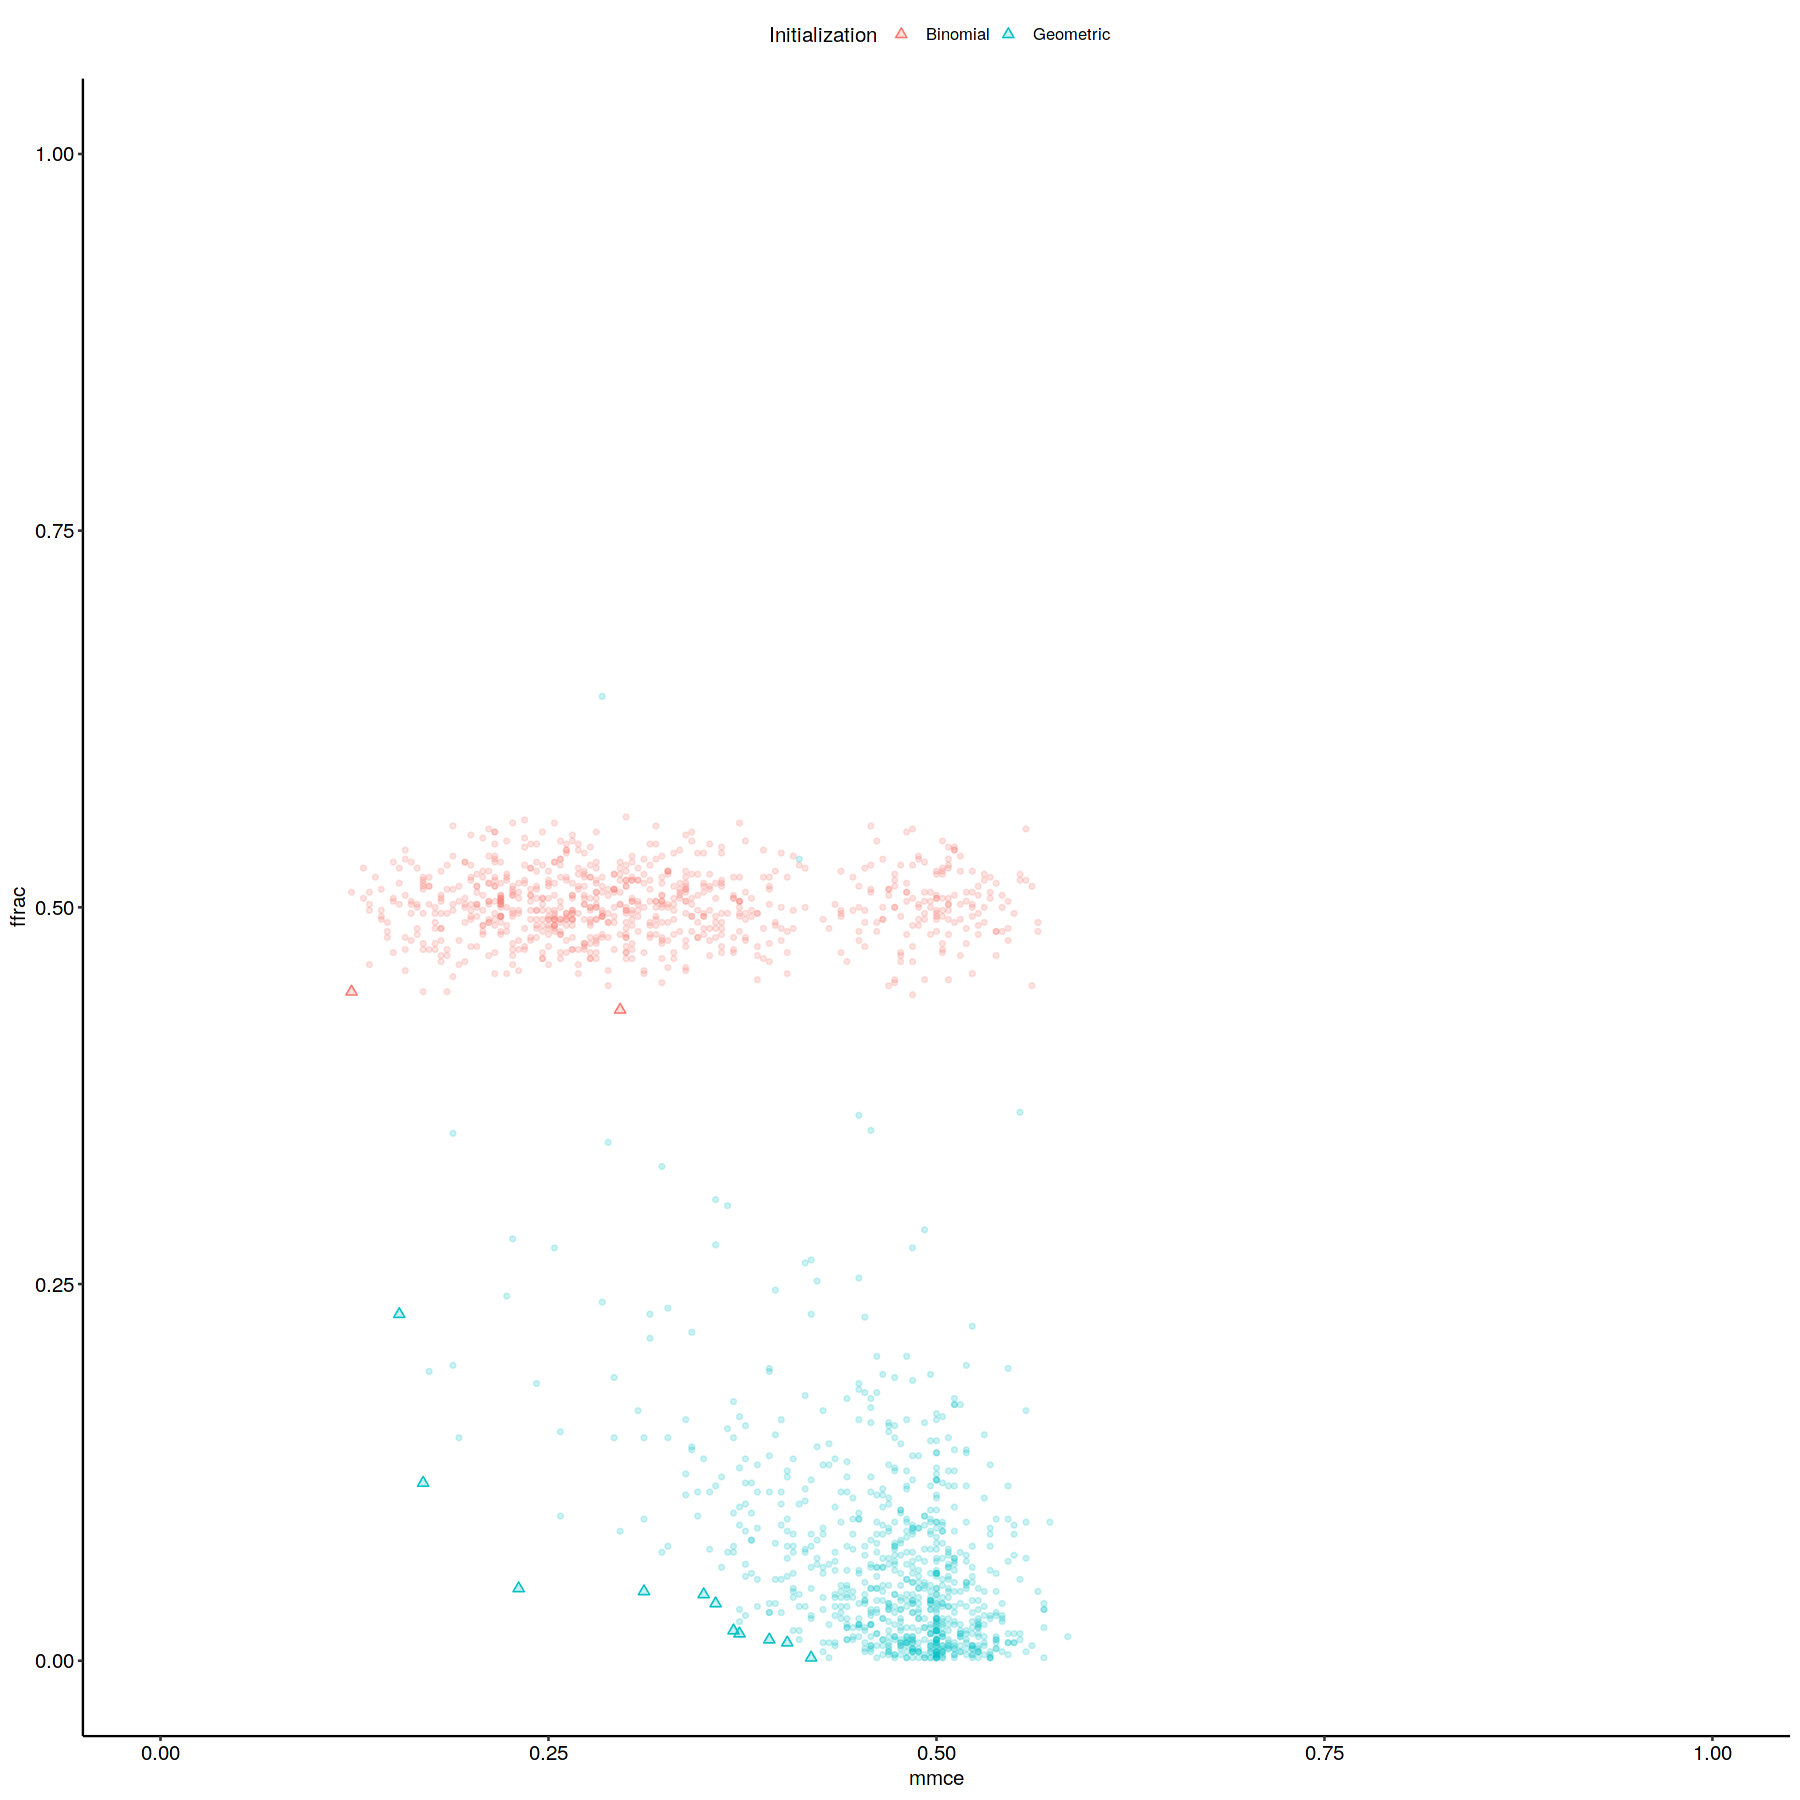

In [59]:
p1 = ggplot()
p1 = p1 + geom_point(data = dfp, aes(x = perf.hout.perf, y = meanfeat.propfeat, colour = variant), fill = "white", alpha = 0.2, size = 1)
p1 = p1 + geom_point(data = dfp[nondominated == TRUE, ], aes(x = perf.hout.perf, y = meanfeat.propfeat, colour = variant), shape = 2, size = 2)
p1 = p1 + labs(colour = "Initialization")
p1 = p1 + xlab("mmce") + ylab("ffrac") # + theme(legend.direction = "vertical")
# p1 = p1 + guides(shape = guide_legend(order = 2),col = guide_legend(order = 1), fill = FALSE)
p1 = p1 + ylim(c(0, 1)) + xlim(c(0, 1))
p1 = p1 + scale_color_discrete(breaks=c("Binomial", "Geometric", "Filter-Ensemble"))
p1

In [60]:
ggsave("viz/example_geom_init.pdf", p1, width = 5, height = 4.5)

## Analysis

The versions we compare are: 

|Variant | $\text{init}_{\text{dist}}$ | $\text{init}_{\text{filter}}$ | $\text{mut}_{\text{HWP}}$ |  $\text{mut}_{\text{filter}}$ | $\text{mut}_{\text{sa}}$ |  
|---|---|---|---|---|---|
|NSGA2 (1) | binom | No | No | No | No |
|(2) | uniform | No | No | No | No |
|(3)| geom | No | No | No | No |
|(4)| geom | No | Yes | No | No |
|(5)| geom | Yes | Yes | No | No |
|GA-MO-FE (6)| geom | Yes |Yes | Yes | No |
| (7) | geom | Yes | Yes | Yes | Yes |

In [38]:
# Experiments to compare
variants_internal = c("O", "OI", "OG", "OGH", "OGHFi", "OGHFiFm", "OGHFiFmS")
variants = c("(1)", "(2)", "(3)", "(4)", "(5) = GA-MO", "(6) = GA-MO-FE", "(7)")
names(variants) = variants_internal # for revaluing later 

In [40]:
# read the files 
df = getObjSummaries(datasets = datasets, experiments = variants_internal)
df$variant = revalue(df$variant, variants)

In [41]:
# sanity check if all is read properly
dft = df[gen == 0, ]
grid = setDT(expand.grid(variants, datasets))
names(grid) = c("variant", "problem")

test = dft[, .N, by = c("variant", "problem")]
test = merge(grid, test, by = c("variant", "problem"), all.x = TRUE)

# both should be 0 
test[is.na(N), ]
test[N != 30, ]

variant,problem,N
<chr>,<chr>,<int>


variant,problem,N
<chr>,<chr>,<int>


## Analysis

In [44]:
measure.vars = c("eval.domHV", "true.hout.domHV", "naive.hout.domHV")

### Dominated Hypervolume vs. Evaluations 

In [47]:
# aggregate over replications 
dfp = df[, lapply(.SD, mean, na.rm = TRUE), by = c("variant", "evals", "problem", "learner"), .SDcols = measure.vars]

Warning message:
“Removed 268 rows containing missing values (geom_path).”


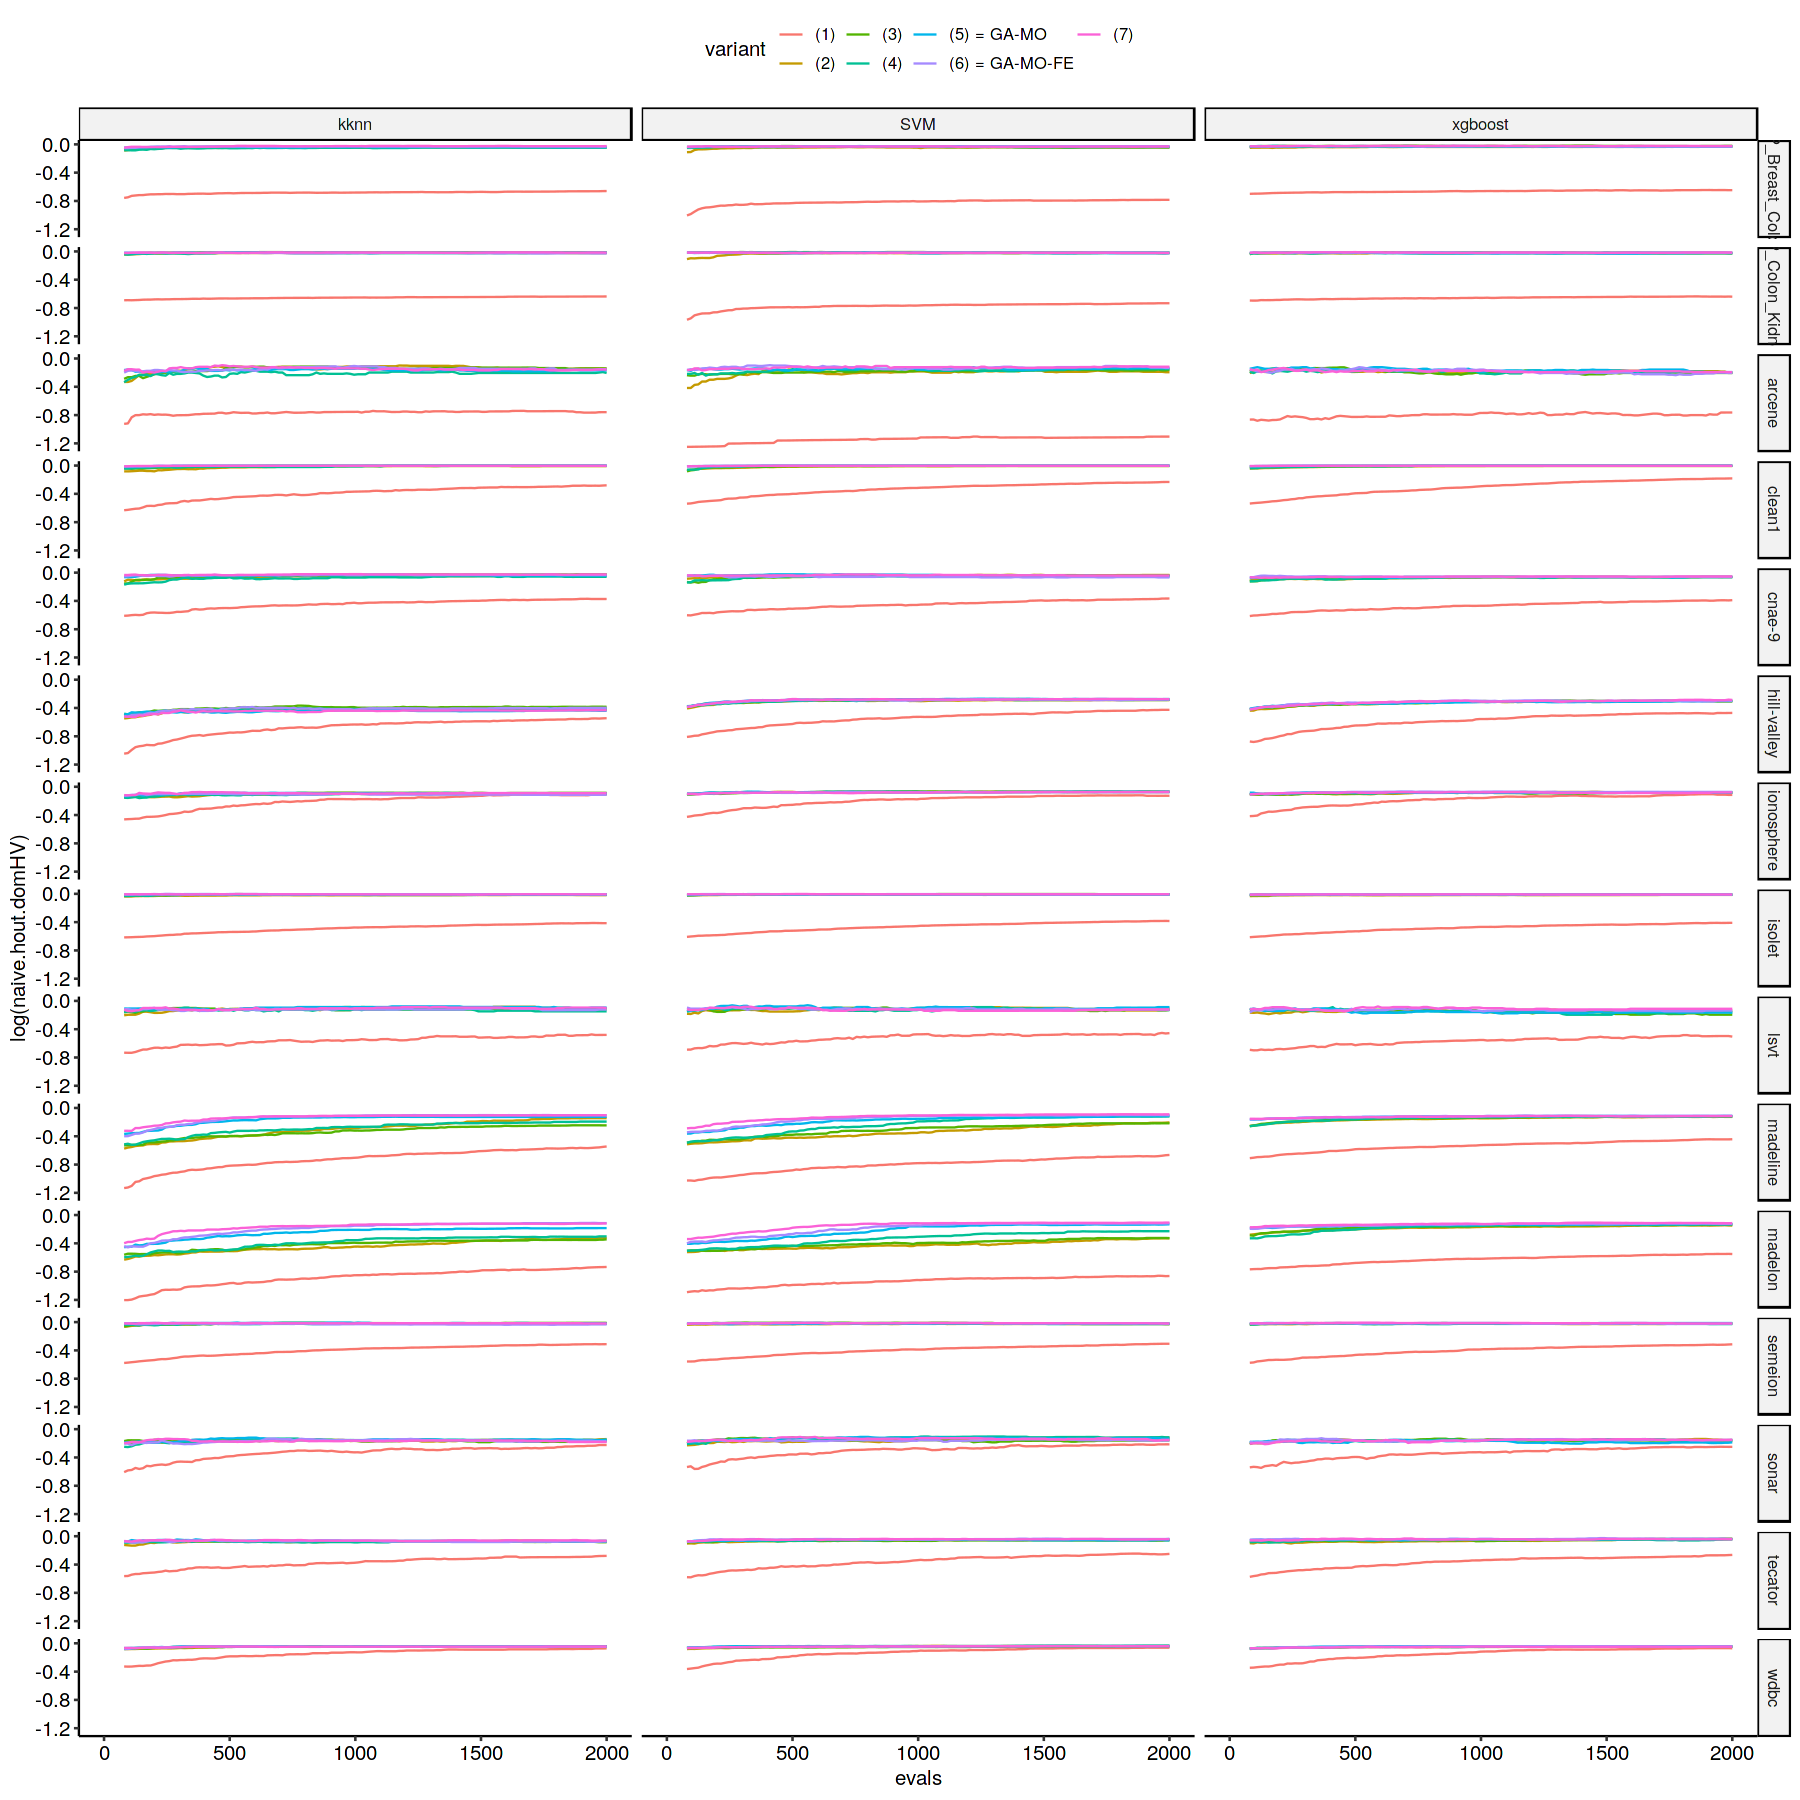

In [48]:
p = ggplot(data = dfp, aes(x = evals, y = log(naive.hout.domHV), colour = variant)) + geom_line() + xlim(c(0, 2000))
p = p + facet_grid(problem ~ learner)
p

In [49]:
plist = list()
for (prob in unique(dfp$prob)) {
    for (lrn in unique(dfp$learner)) {
        p = ggplot(data = dfp[problem == prob & learner == lrn, ], aes(x = evals, y = naive.hout.domHV, colour = variant)) + geom_line()
        p = p + ggtitle(paste(lrn, "on", prob)) + xlim(c(0, 2000))
        plist[[paste(prob, lrn, sep = ".")]] = p
    }
}

Warning message:
“Removed 268 rows containing missing values (geom_path).”


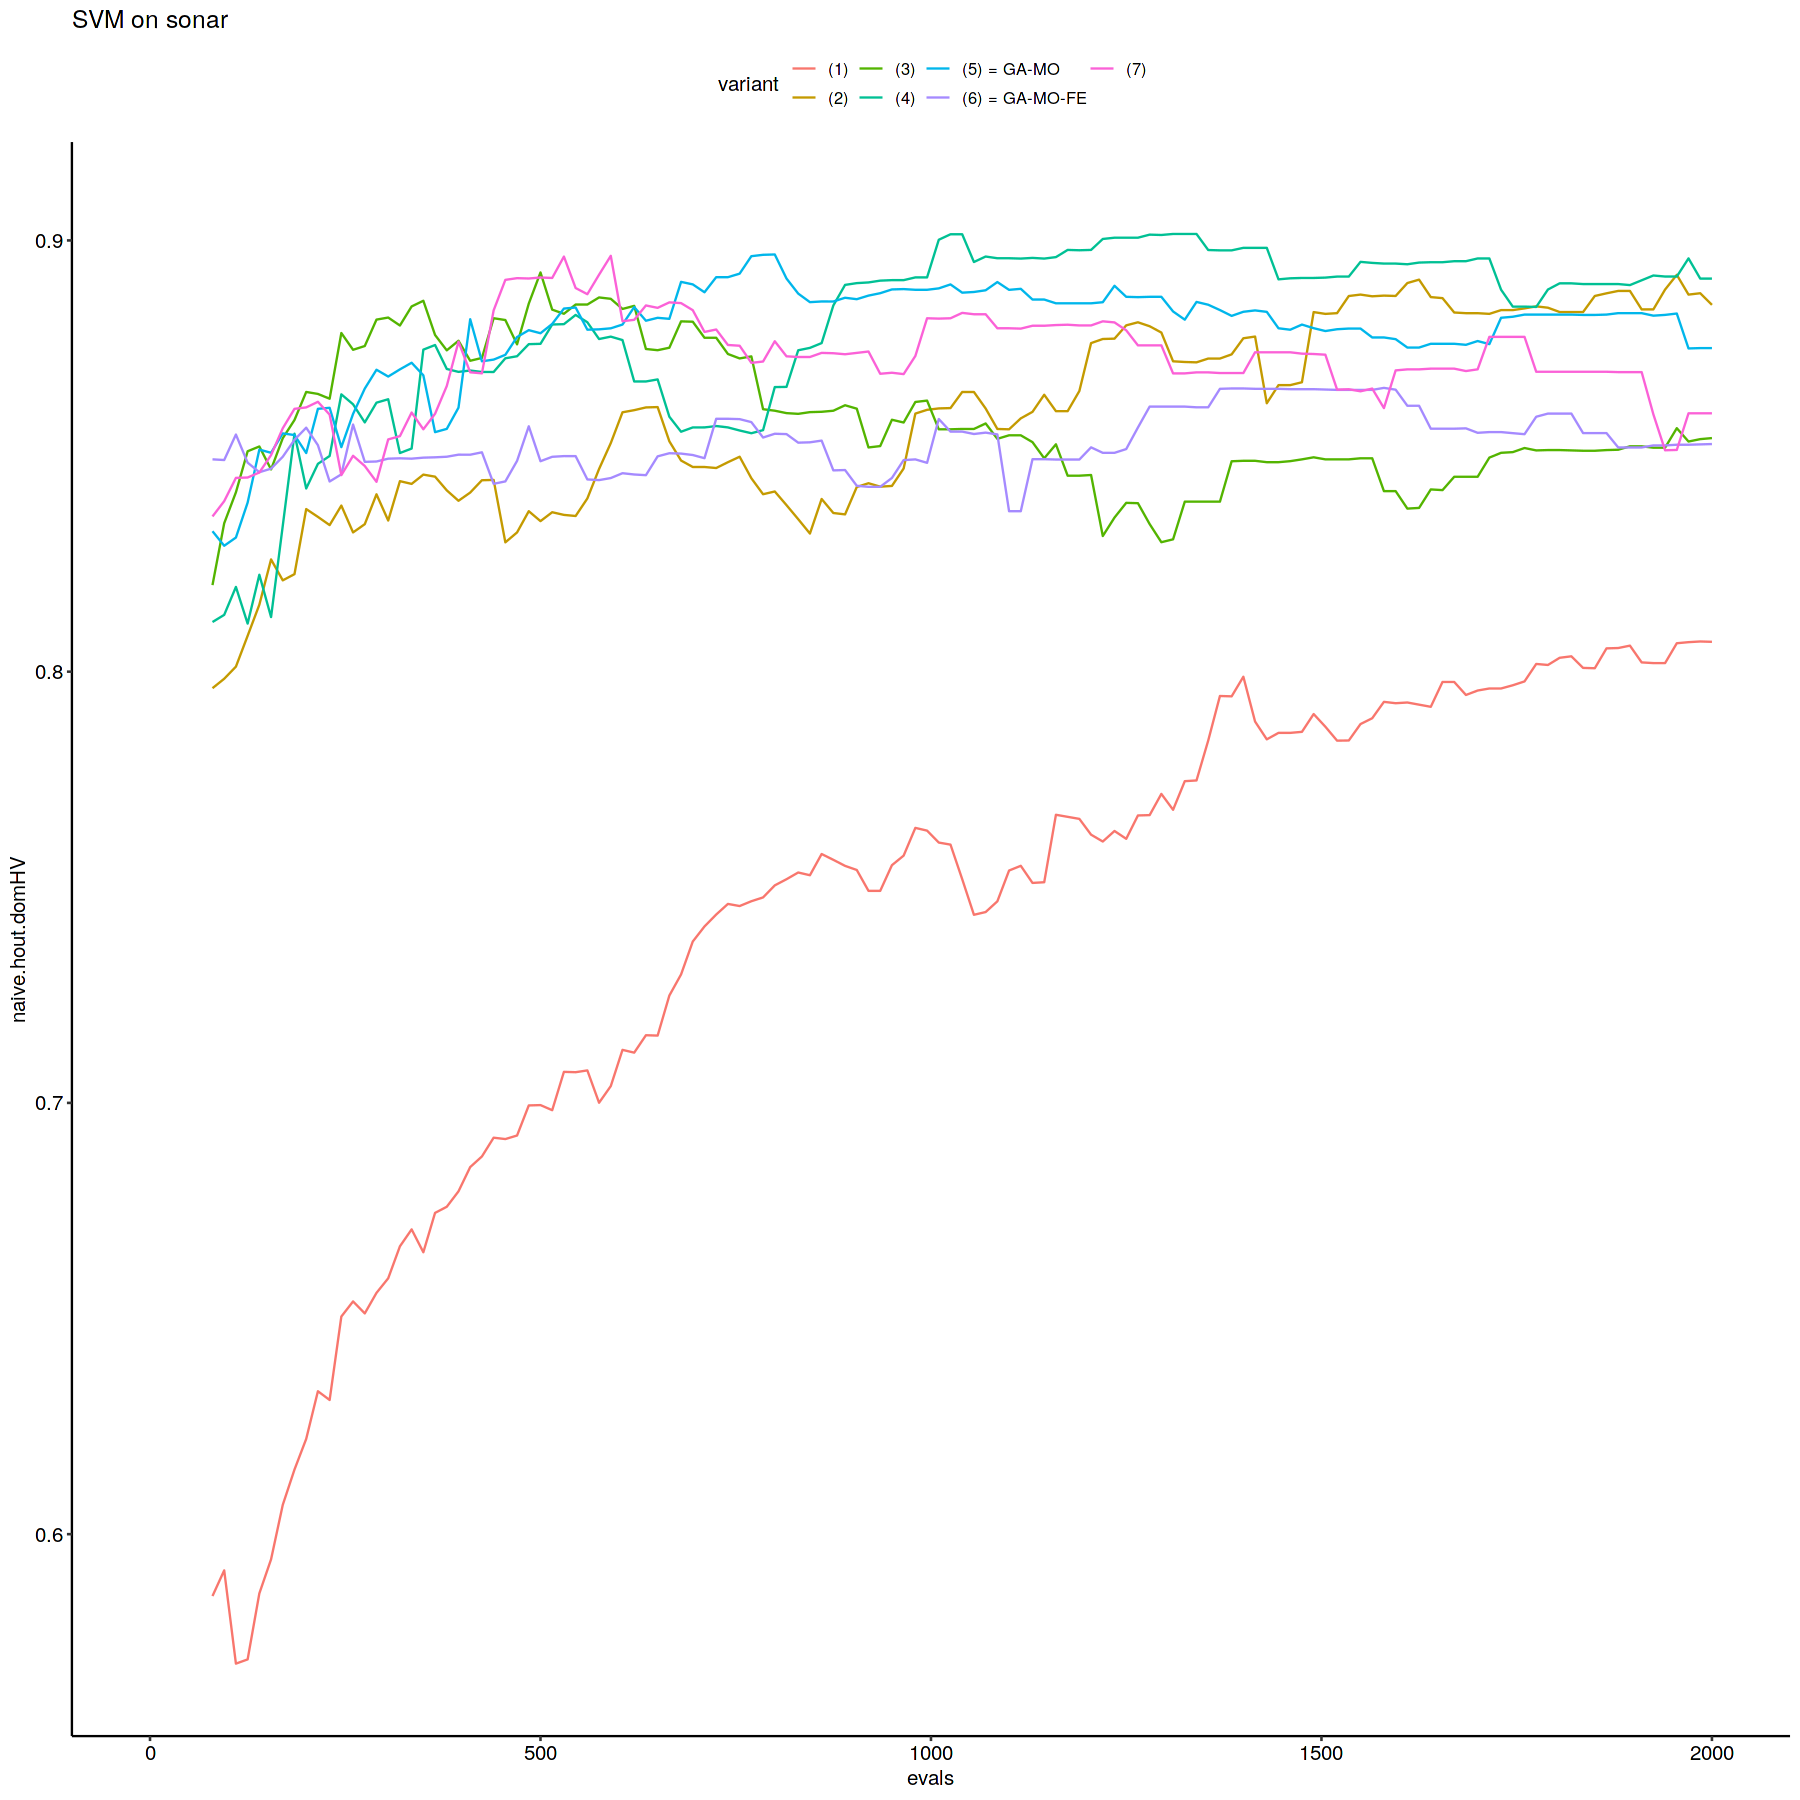

In [50]:
plist[[1]] 

### Significance Testing

In [53]:
for (measure in c("eval.domHV", "naive.hout.domHV", "true.hout.domHV")) {
    dfp$problem = paste(dfp$learner, dfp$problem, sep = "-")
    ev = 2000
    dfp = dfp[evals == ev, ]
    dft = dcast(dfp[, c("problem", "variant", ..measure)], problem ~ variant)
    rownames(dft) = dft$problem
    dft$problem = NULL
    m = gsub("\\.", "", measure)
    
    pdf(paste("viz/RQ0-CD_", m, ".pdf", sep = ""), width = 6, height = 4.5) 
    p = plotCD(dft, alpha = 0.05, cex = 1.25)
    p 
    dev.off()
    # ggsave(paste("viz/F1-Ablation-Study/CD_", measure, ".pdf"), p, width = 4.5, height = 4.5)
}


Using eval.domHV as value column: use value.var to override.

Using naive.hout.domHV as value column: use value.var to override.

Using true.hout.domHV as value column: use value.var to override.



### Rank Analysis

In [54]:
dfr = df[, .(meandomHV = mean(naive.hout.domHV)), by = c("learner", "variant", "problem", "evals")]

In [55]:
# average out replications first
dfr = df[, .(meandomHV = mean(naive.hout.domHV)), by = c("learner", "variant", "problem", "evals")]
# rank across all problems and learners
dfr = dfr[, `:=` (rank_variant = rank(meandomHV)), by = c("learner", "problem", "evals")]
# compute mean rank 
res_ovr = dfr[, .(mean.domHV = mean(meandomHV), mean.rank = mean(rank_variant), sd.domHV = sd(meandomHV) / sqrt(length(meandomHV))), by = c("evals", "variant")]

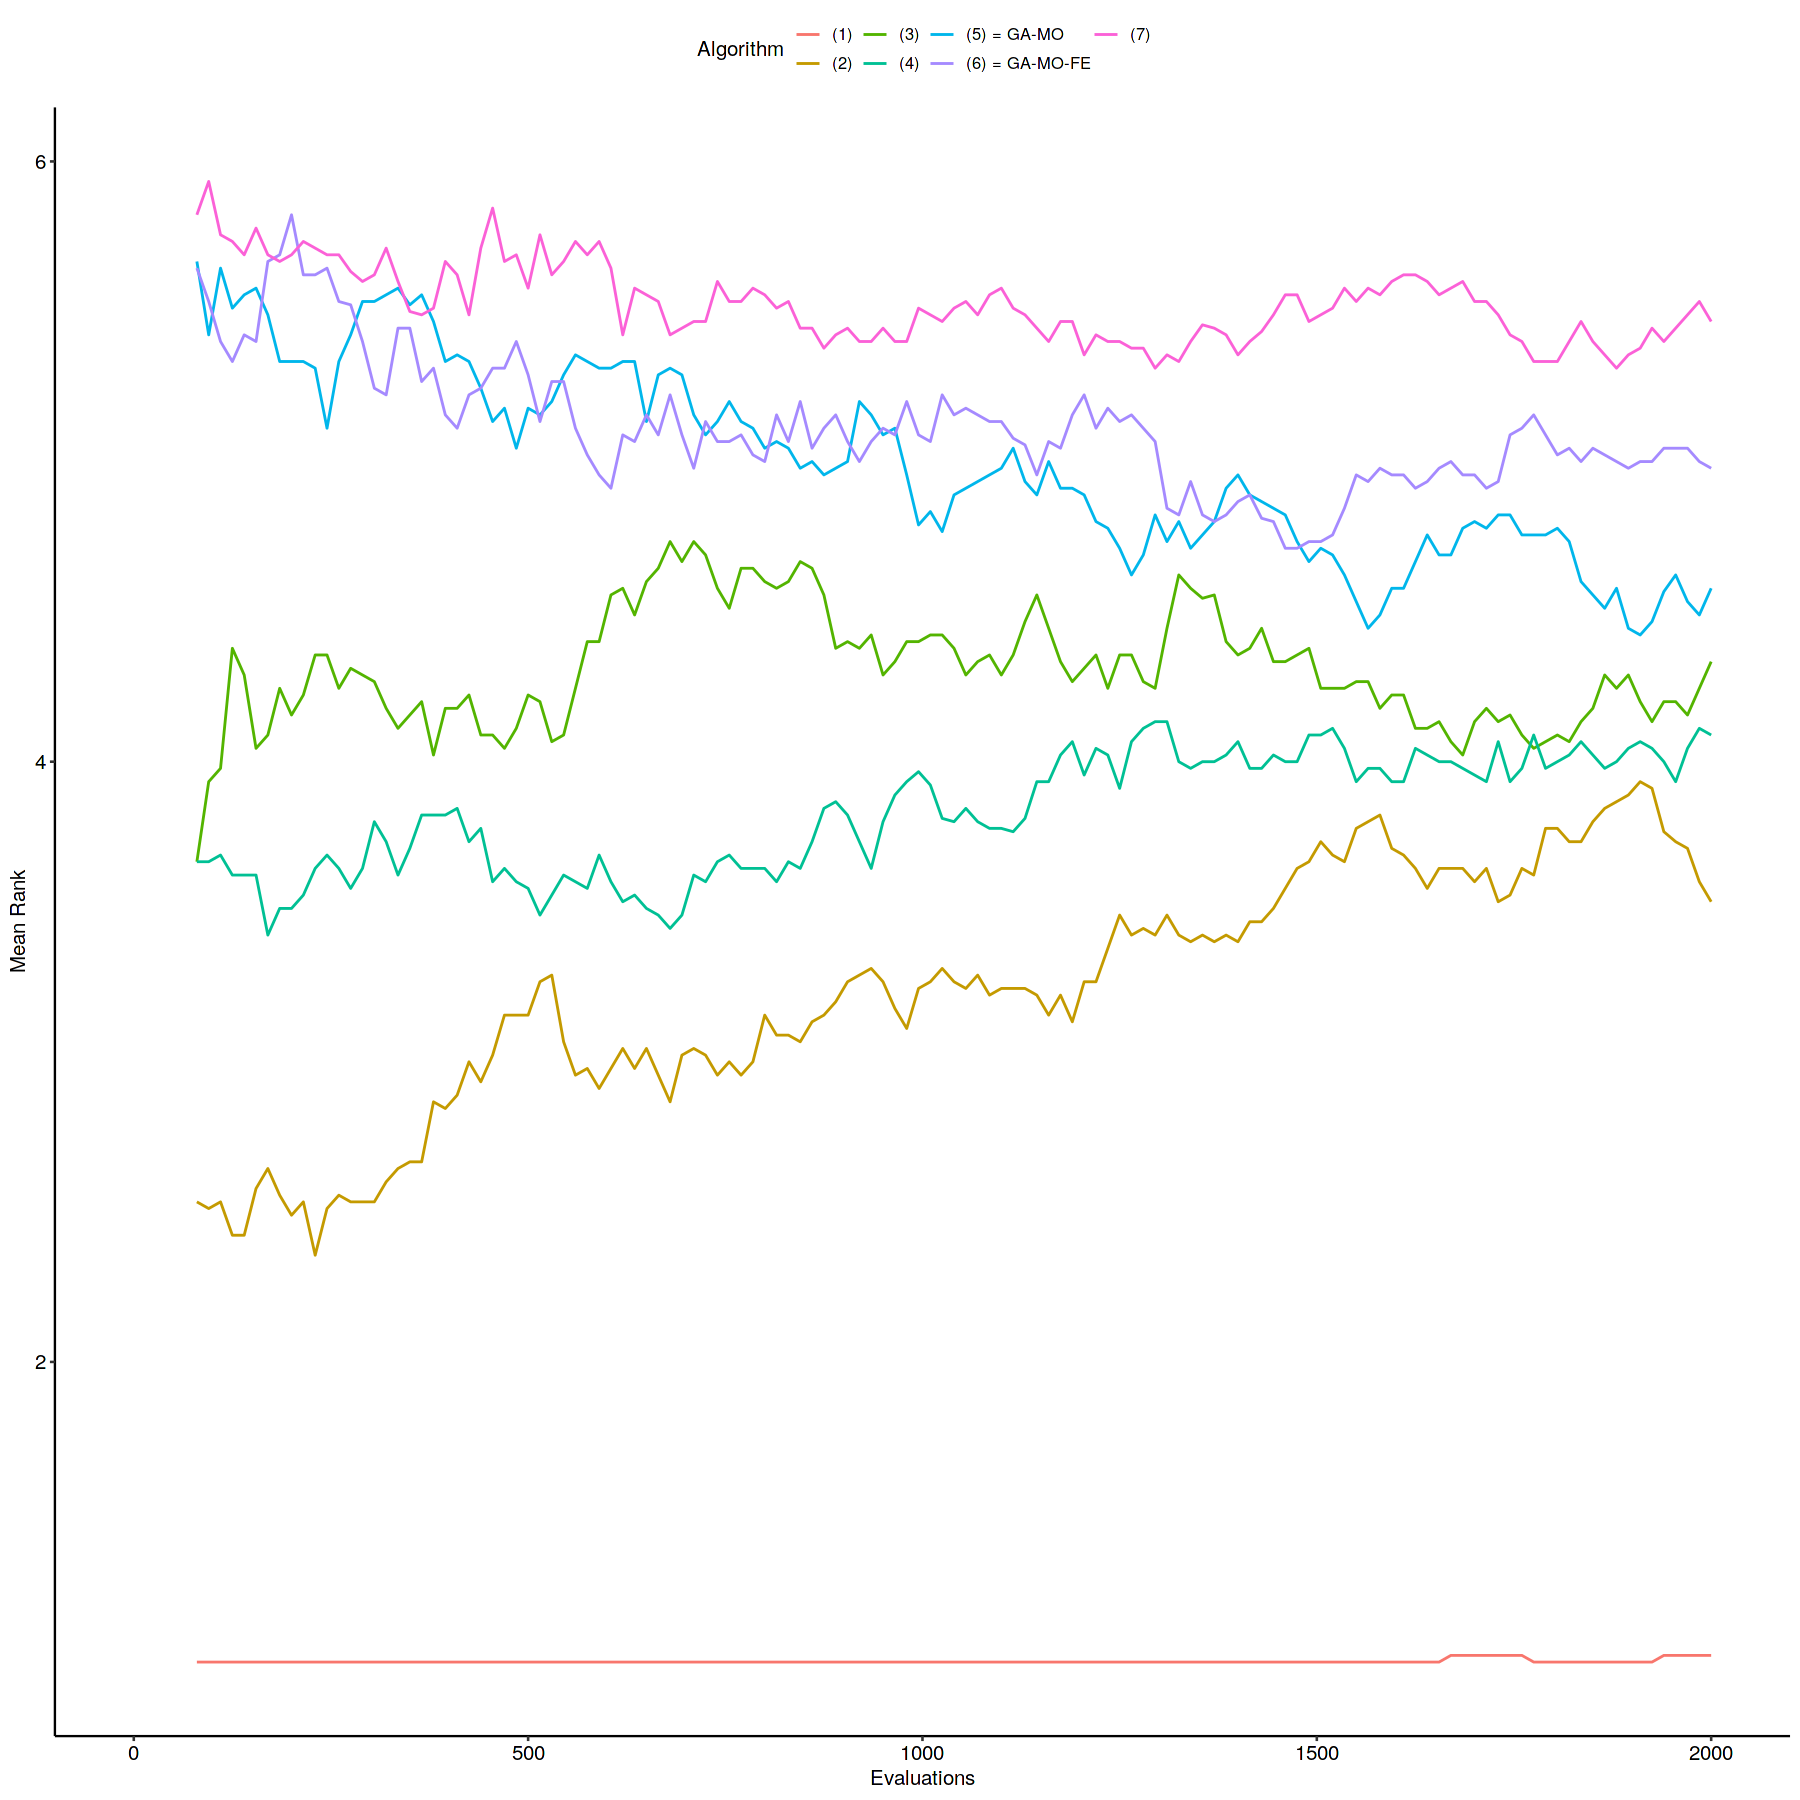

In [58]:
p1 = ggplot()
p1 = p1 + geom_line(data = res_ovr[evals <= 2000, ], aes(x = evals, y = mean.rank, colour = variant), size = 0.6)
p1 = p1 + labs(colour = "Algorithm") 
p1 = p1 + xlab("Evaluations") + xlim(c(0, 2000)) + ylab("Mean Rank") 
p1

In [59]:
ggsave("viz/RQ0-ranks_naive_domHV.pdf", p1, width = 7, height = 4.5)